Download the Data

In [1]:
!wget --no-check-certificate https://s3.amazonaws.com/fast-ai-nlp/amazon_review_full_csv.tgz


--2022-01-12 13:10:52--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_full_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.130.117
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.130.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643695014 (614M) [application/x-tar]
Saving to: ‘amazon_review_full_csv.tgz’

amazon_review_full_ 100%[===================>] 613.88M  41.1MB/s    in 17s     

2022-01-12 13:11:10 (35.3 MB/s) - ‘amazon_review_full_csv.tgz’ saved [643695014/643695014]



Import Libraries

In [2]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 895 kB 46.4 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import tensorflow as tf
import torch

from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
from nltk.corpus import stopwords
import nltk, string

Extract the Dataset

In [4]:
!sudo tar -xvf amazon_review_full_csv.tgz

amazon_review_full_csv/
amazon_review_full_csv/train.csv
amazon_review_full_csv/readme.txt
amazon_review_full_csv/test.csv


Read the Train Data

In [5]:
train_path = r'/content/amazon_review_full_csv/train.csv'

train_data= pd.read_csv(train_path, names=['class_index', 'review_title', 'review_text'])
train_data.head()

,class_index,review_title,review_text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [6]:
test_path = r'/content/amazon_review_full_csv/test.csv'
test_data = pd.read_csv(test_path, names=['class_index', 'review_title', 'review_text'])
test_data.head()

,class_index,review_title,review_text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,2,Oh dear,I was excited to find a book ostensibly about ...
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."


In [7]:
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Function to clean up text

In [8]:
def clean_text(sentences):
  sentences = str(sentences)
  sentences = sentences.lower()
  sentences = sentences.replace(",", " , ").replace(".", " . ")
  sentences = sentences.replace("-", " - ").replace("/", " / ")
  table = str.maketrans('', '', string.punctuation)
  words = sentences.split()
  filtered_sentence = ""
  for word in words:
    word = word.translate(table)
    if word not in stopwords:
      filtered_sentence = filtered_sentence + word + " "
  return filtered_sentence


In [9]:
# testing the CLEAN_TEXT function 

new_text = clean_text(train_data['review_text'][2])

print("Original text: {}\n".format(train_data['review_text'][2]))
print("Cleaned text: {}\n".format(new_text))


Original text: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.

Cleaned text: im reading lot reviews saying best game soundtrack figured id write review disagree bit  opinino yasunori mitsudas ultimate masterpiece  music timeless im listening years beauty simply refuses fade  price tag pretty staggering must say  going buy cd much money  one feel would worth every penny  



Clean up the review title as this would be used to for model training

In [10]:
train_review_title = train_data['review_title'].map(clean_text).tolist()
test_review_title = test_data['review_title'].map(clean_text).tolist()

train_ratings = train_data.class_index.tolist()
test_ratings = test_data.class_index.tolist()

View the output

In [11]:
print(train_review_title[:5])
print('\n')
print(train_ratings[:5])

['like funchuck ', 'inspiring ', 'best soundtrack ever anything  ', 'chrono cross ost ', 'good true ']


[3, 5, 5, 4, 5]


In [12]:
# view test output
print(test_review_title[:5])

['mens ultrasheer ', 'surprisingly delightful ', 'works  advertised ', 'oh dear ', 'incorrect disc ']


In [13]:
max_len = len(max(train_review_title))
# get the length of the longest Sequence
max_len 

35

In [14]:
# check that the MAX length of test data is not larger than on train data
len(max(test_review_title))

11

In [15]:
# view what the longest text looks like
max(train_review_title)

'“you can’t drop atom bomb chicago” '

Tokenize the  texxt

In [16]:
tokenizer = Tokenizer(num_words=20000, oov_token='<oov>')
tokenizer.fit_on_texts(train_review_title)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_review_title)
testing_sequences = tokenizer.texts_to_sequences(test_review_title)

training_padded = pad_sequences(training_sequences, padding='post')
testing_padded = pad_sequences(testing_sequences, padding='post')

In [17]:
# convert the inputs to Numpy array for easier assimilation
training_padded = np.array(training_padded)
training_labels = np.array(train_ratings)

testing_padded = np.array(testing_padded)
testing_labels = np.array(test_ratings)

Perform some EDA on the dataset

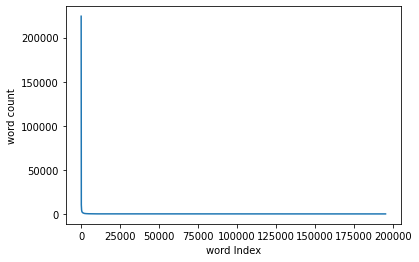

In [18]:
# plot shows the Word count to word frequency
wc = tokenizer.word_counts
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))

xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])
plt.plot(xs,ys)
plt.xlabel('word Index')
plt.ylabel('word count')

plt.show()

The above plot shows that a Vocabulary of 20K is too much and would cause Over-fitting, so we need to reduce the Voc size so that we would only capture key-words and not junks, as many words appear only once.

In [19]:
# view the word count data
word_count_df = pd.DataFrame(newlist.items(), columns=['word', 'count'])
word_count_df.head(5)

,word,count
0,good,224194
1,great,216353
2,book,131720
3,best,68411
4,one,55370


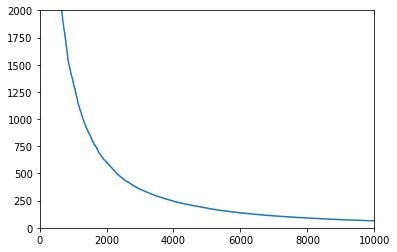

In [20]:
# let's zoom into the plot to get the tipping point
plt.plot(xs,ys)
plt.axis([0,10000,0,2000])
plt.show()

Let's reduce our Vocabulary to only 10K to avoid overfitting

In [21]:
tokenizer = Tokenizer(num_words=10000, oov_token='<oov>')
tokenizer.fit_on_texts(train_review_title)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_review_title)
testing_sequences = tokenizer.texts_to_sequences(test_review_title)

training_padded = pad_sequences(training_sequences, padding='post', maxlen=max_len, truncating='post')
testing_padded = pad_sequences(testing_sequences, padding='post', maxlen=max_len, truncating='post')

In [22]:
training_padded = np.array(training_padded)
training_labels = np.array(train_ratings)

testing_padded = np.array(testing_padded)
testing_labels = np.array(test_ratings)

In [23]:
# add new Axis
# training_padded = training_padded[..., np.newaxis]
# training_labels = training_labels[..., np.newaxis]

# testing_padded = testing_padded[..., np.newaxis]
# testing_labels = testing_labels[..., np.newaxis]


Let's first try training from scratch before trying Pre-trained data

Store the ratings in a label Variable

In [24]:
labels = sorted(set(training_labels))
labels

[1, 2, 3, 4, 5]

In [25]:
# model = Sequential([
#                     layers.Embedding(10000, 16, input_length=max_len),
#                     layers.GlobalAveragePooling1D(),
#                     layers.Dense(8, activation='relu'),
#                     layers.Dropout(0.25),
#                     layers.Dense(len(labels), activation='softmax')
# ])

embedding_dim = 64

model = Sequential([
                    layers.Embedding(10000, embedding_dim),
                    layers.Bidirectional(layers.LSTM(embedding_dim, return_sequences=True, dropout=0.2)),
                    layers.Bidirectional(layers.LSTM(embedding_dim, dropout=0.2)),
                    layers.Dense(16, activation='relu'),
                    layers.Dropout(0.25),
                    layers.Dense(5, activation='softmax')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

One Hot encode the target labels

In [26]:
ohe = OneHotEncoder().fit(training_labels.reshape(-1, 1))
label_1 = ohe.transform(training_labels.reshape(-1, 1)).toarray()
label_2 = ohe.transform(testing_labels.reshape(-1, 1)).toarray()

In [27]:
# training was taking too long so

# history = model.fit(training_padded,label_1,epochs=40,batch_size=4096,validation_data=(testing_padded,label_2))

I wanted to first try local training and present the results, but it was taking too long. So I would use BERT model as advised. The review text would aslo be used instead of review title.

In [28]:
# download the pre-traained BERT model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')


# function that would be used to get the scoring
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1


Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

In [29]:
# check out class_index of the first class_index
print(test_data['class_index'][0])
print(test_data['class_index'][1])

1
4


In [30]:
# let's try to get a prediction from our BERT model
print(sentiment_score(test_data['review_text'][0]))
print(sentiment_score(test_data['review_text'][1]))

2
4


In [45]:
test_data['class_index'][1911]

4

In [44]:
sentiment_score(test_data['review_text'][1911])

4

BERT model can only take in 512 max for prediction. So we would need a way to pass in just 512 variables at a time to get predictions from them.

Only testing on 1000 texts, as trying to test on the whole test would take a lot odf time, and today's the deadline.

In [61]:
pred = test_data['review_text'][:1000].map(lambda x: sentiment_score(x))

I got an accuracy score of 55% on just 1000 datasets. 

In [66]:
accuracy_score(test_data['class_index'][:1000], pred.values)

0.551

**Suggestions to improve model**

Currently, raw strings are being passed onto this model as inputs, performing some preprocessing before feeding the data can help increase the model accuracy. Also, training a neural network alongside a pretrained model would significantly increase the model accuracy as this would help tailor the model to our problem. 